In [112]:
import pandas as pd
import plotly.express as px
import math
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import Dict, List

In [113]:
TRAIN_PATH = "../data/raw/train2.tsv"
VAL_PATH = "../data/raw/val2.tsv"
TEST_PATH = "../data/raw/test2.tsv"

In [114]:
train_df = pd.read_csv(TRAIN_PATH, sep="\t", names=["id", "statement_json", "label", "statement", "subject", "speaker", "speaker_title", "state_info", "party_affiliation", "barely_true_count", "false_count", "half_true_count", "mostly_true_count", "pants_fire_count", "context", "justification"])
val_df = pd.read_csv(VAL_PATH, sep="\t", names=["id", "statement_json", "label", "statement", "subject", "speaker", "speaker_title", "state_info", "party_affiliation", "barely_true_count", "false_count", "half_true_count", "mostly_true_count", "pants_fire_count", "context", "justification"])
test_df = pd.read_csv(TEST_PATH, sep="\t", names=["id", "statement_json", "label", "statement", "subject", "speaker", "speaker_title", "state_info", "party_affiliation", "barely_true_count", "false_count", "half_true_count", "mostly_true_count", "pants_fire_count", "context", "justification"])

In [115]:
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 500

# Basic statistics

In [116]:
len(train_df)

10267

In [117]:
len(val_df)

1284

In [118]:
len(test_df)

1283

In [119]:
train_df.columns

Index(['id', 'statement_json', 'label', 'statement', 'subject', 'speaker',
       'speaker_title', 'state_info', 'party_affiliation', 'barely_true_count',
       'false_count', 'half_true_count', 'mostly_true_count',
       'pants_fire_count', 'context', 'justification'],
      dtype='object')

In [120]:
train_df.head()

,id,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification
0,0,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,"That's a premise that he fails to back up. Annie's List makes no bones about being comfortable with candidates who oppose further restrictions on late-term abortions. Then again, this year its backing two House candidates who voted for more limits."
1,1,10540.json,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started when natural gas took off That started to begin in President (George W. ) Bushs administration. ""No doubt, natural gas has been gaining ground on coal in generating electricity. The trend started in the 1990s but clearly gained speed during the Bush administration when the production of natural gas -- a competitor of coal -- picked up. But analysts give little credit or blame to Bush for that trend. They note that other factors, such as technologic..."
2,2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,"Obama said he would have voted against the amendment if he had been present. So though Clinton may have ""agreed"" with McCain on the issue, they did not technically vote the same way on it. To say that voting for Kyl-Lieberman is ""giving George Bush the benefit of the doubt on Iran"" remains a contentious issue. But Obama's main point is that Clinton and McCain were on the same side, and that is correct."
3,3,1123.json,false,Health care reform legislation is likely to mandate free sex change surgeries.,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,"The release may have a point that Mikulskis comment could open the door to ""medically necessary"" coverage which conceivably may include sex-change operations. But it's unclear whether her amendment will remain in the legislation, and there's nothing specific in the legislation on sex-change procedures and nothing else solid that indicates such coverage will be provided. The news release cherry-picked a few fleeting references to gender and sexual orientation in completely unrelated contexts ..."
4,4,9028.json,half-true,The economic turnaround started at the end of my term.,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround started at the end of my term. ""During Crists last year in office, Floridas economy experienced notable gains in personal income and industrial production, and more marginal improvements in the unemployment rate and in payroll employment. But GDP didnt grow again until Scott took office. Economists say Crist deserves some credit for the economic turnaround because he accepted federal stimulus dollars, but they add that any state is inevitably buffeted..."


In [121]:
# Drop rows with no label
train_df.dropna(subset=["label"], inplace=True)
len(train_df)

10267

In [122]:
# Normalized distribution of labels (roughly equal except for the flagrantly false statement "pants-fire")
train_df.label.value_counts(normalize=True)

half-true      0.206682
false          0.194604
mostly-true    0.191487
true           0.163826
barely-true    0.161391
pants-fire     0.082010
Name: label, dtype: float64

In [123]:
label_ratios = train_df.label.value_counts(normalize=True)
px.bar(label_ratios, x=label_ratios.index, y=label_ratios.values, labels={"index": "label", "y": "ratios"}, title="Label Distribution")

In [124]:
# Notice a huge number of speaker titles
train_df.speaker_title.nunique()

1187

In [125]:
train_df.speaker_title[train_df.speaker_title.notnull()]

0                                 State representative
1                                       State delegate
2                                            President
5                           Wisconsin Assembly speaker
7                                            President
                             ...                      
10255                                  President-Elect
10257                                          Senator
10258                      State Senator, 8th District
10259                      Senior editor, The Atlantic
10266    chairman of the Republican National Committee
Name: speaker_title, Length: 7367, dtype: object

In [126]:
# A lot of repetition in speaker_title - not canonicalized
train_df.speaker_title.value_counts()[:20]

President                        497
U.S. Senator                     480
Governor                         391
President-Elect                  274
U.S. senator                     263
Presidential candidate           254
Former governor                  180
U.S. Representative              172
Milwaukee County Executive       150
Senator                          148
State Senator                    108
U.S. representative              103
U.S. House of Representatives    102
Attorney                          81
Congressman                       80
Social media posting              78
Governor of New Jersey            78
State Representative              73
Co-host on CNN's "Crossfire"      73
State representative              66
Name: speaker_title, dtype: int64

In [127]:
train_df.speaker.value_counts()

barack-obama                   493
donald-trump                   274
hillary-clinton                239
mitt-romney                    180
scott-walker                   150
                              ... 
trebor-banstetter                1
lgbt-progress                    1
new-georgia-encyclopedia         1
yes-62-death-penalty-repeal      1
anthony-bucco                    1
Name: speaker, Length: 2915, dtype: int64

In [128]:
train_df.speaker.nunique()

2915

In [129]:
affiliation_counts = train_df.party_affiliation.value_counts()
px.bar(affiliation_counts, x=affiliation_counts.index, y=affiliation_counts.values, labels={"index": "affiliation", "y": "counts"}, title="Counts Per Affiliation")

In [130]:
# Convert from 6-way scale to binary scale
def get_binary_label(label: str) -> bool:
    if label in {"pants-fire", "barely-true", "false"}:
        return False
    elif label in {"true", "half-true", "mostly-true"}:
        return True

In [131]:
train_df["binary_label"] = train_df.label.apply(get_binary_label)

In [132]:
party_groups = train_df.groupby(["party_affiliation"])

In [133]:
party_groups.get_group("republican").binary_label.value_counts(normalize=True)

True     0.502329
False    0.497671
Name: binary_label, dtype: float64

In [134]:
party_groups.get_group("democrat").binary_label.value_counts(normalize=True)

True     0.661584
False    0.338416
Name: binary_label, dtype: float64

In [135]:
train_df.binary_label.value_counts(normalize=True)

True     0.561995
False    0.438005
Name: binary_label, dtype: float64

In [136]:
unigram_lens = train_df.statement.str.split().str.len()

In [137]:
px.histogram(unigram_lens, x=unigram_lens.values, labels={"x": "unigram lens"}, title="Unigram Length Distribution")

In [138]:
unigram_lens.median()

17.0

In [139]:
unigram_lens.mean()

17.90990552254797

In [140]:
unigram_lens.max()

66

In [141]:
# Ran into some noisy labels for certain columns so have to remove it
train_df[train_df.pants_fire_count == "a television interview"]

/Users/mihaileric/anaconda3/envs/fake-news/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



,id,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification,binary_label


In [142]:
# Drop column with invalid type for `pants_fire`
train_df.drop(6134, inplace=True)

In [143]:
# Separate true samples from false ones
true_ex = train_df[train_df.binary_label == True]
false_ex = train_df[train_df.binary_label == False]

In [144]:
train_df.barely_true_count.describe()

count    10266.000000
mean        11.557276
std         19.001815
min          0.000000
25%          0.000000
50%          2.000000
75%         12.000000
max         70.000000
Name: barely_true_count, dtype: float64

In [145]:
# TODO (mihail): Include feature for credit history counts (binned)
barely_true_counts = train_df.barely_true_count.value_counts().sort_index()
px.bar(barely_true_counts, x=barely_true_counts.index, y=barely_true_counts.values, labels={"index": "credit", "y": "counts"}, title="Barely True Credit Distribution")

In [146]:
px.histogram(train_df, x="barely_true_count", labels={"x": "credit score"}, title="Barely True Credit Histogram", nbins=10)

In [147]:
barely_true_counts.values

array([3032, 1516,  817,  490,  236,  317,  190,  237,  171,  247,  104,
        289,  112,   50,  115,   70,   69,   63,  135,   56,  150,  115,
        142,  148,  117,  180,   93,  239,  273,  493])

In [148]:
train_df.false_count.describe()

count    10266.000000
mean        13.306546
std         24.122985
min          0.000000
25%          0.000000
50%          2.000000
75%         15.000000
max        114.000000
Name: false_count, dtype: float64

In [149]:
train_df.half_true_count.describe()

count    10266.000000
mean        17.195695
std         35.951114
min          0.000000
25%          0.000000
50%          3.000000
75%         13.000000
max        160.000000
Name: half_true_count, dtype: float64

In [150]:
train_df.mostly_true_count.describe()

count    10266.000000
mean        16.491720
std         36.255254
min          0.000000
25%          0.000000
50%          3.000000
75%         11.000000
max        163.000000
Name: mostly_true_count, dtype: float64

In [151]:
train_df.pants_fire_count.describe()

count    10266.000000
mean         6.198617
std         16.110747
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max        105.000000
Name: pants_fire_count, dtype: float64

In [152]:
train_df.pants_fire_count.astype(float).describe()

count    10266.000000
mean         6.198617
std         16.110747
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max        105.000000
Name: pants_fire_count, dtype: float64

In [153]:
true_ex.statement.str.split().str.len().describe()

count    5770.000000
mean       18.337782
std         7.798941
min         2.000000
25%        13.000000
50%        17.000000
75%        23.000000
max        66.000000
Name: statement, dtype: float64

In [154]:
false_ex.statement.str.split().str.len().describe()

count    4496.000000
mean       17.361210
std         7.668194
min         2.000000
25%        12.000000
50%        16.000000
75%        22.000000
max        60.000000
Name: statement, dtype: float64

In [155]:
# Sample true and false examples to observe characteristics
true_ex.sample(frac=0.2).head(25)

,id,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification,binary_label
9592,9594,8702.json,true,"60 percent of the jobs lost in the 2008 recession were living-wage jobs. Of the jobs weve gotten back, only 40 percent are living-wage.",jobs,jeff-merkley,U.S. Senator,Oregon,democrat,0.0,1.0,3.0,6.0,0.0,a talk to the Human Services Coalition of Oregon,"Germany had 25,777 megawatts, China had 25,104 megawatts, Spain had 19,149 megawatts and India had 10,926 megawatts. Italy was the country with the sixth largest installed wind power capacity (4,850 megawatts) just over half of Texas' capacity. Not including the U. S. , Texas had installed more wind power than any all but four countries. And more than any other state.",True
5700,5700,7873.json,mostly-true,"If Obamacare is fully implemented, 30 million people will still be without health insurance.",health-care,bob-gibbs,Representative from Ohio's 18th Congressional District,Ohio,republican,0.0,0.0,0.0,1.0,1.0,a tweet,"In 2015, she released a video called ""Flush the TPP"" in which she characterized the agreement as a ""backroom deal"" that ""gives corporations more power than nations. ""Our rating Johnson said he and his running mate were the only candidates who support free trade. Clinton supported NAFTA and in the Senate voted for several smaller trade deals.",True
9370,9372,7322.json,mostly-true,"Says since Australia passed tough gun laws, homicides by firearm have declined almost 60 percent.","crime,government-regulation,guns,public-safety",stephen-king,NaN,NaN,democrat,0.0,0.0,0.0,1.0,0.0,"a Kindle Single essay, 'Guns'","First, it is not an Associated Press article, despite posing as one. Second, an individual justice would not speak for the court when agreeing to hear a case. Third, the case was, in fact, denied cert by the court.",True
1042,1042,10709.json,half-true,"Says Bill Clinton signed a law very similar to, and Barack Obama voted for a law something like, Indianas Religious Freedom Restoration Act.","civil-rights,gays-and-lesbians,legal-issues,religion,supreme-court",scott-walker,Milwaukee County Executive,Wisconsin,republican,26.0,41.0,32.0,40.0,11.0,an interview,"Our rating Walker said Bill Clinton signed a federal law ""very similar to,"" and Obama voted for an Illinois law ""something like,"" Indiana's Religious Freedom Restoration Act. The three laws share the same title and much of the same language, but Indianas law has at least two significant provisions that the other two laws dont. Moreover, the federal and Illinois laws were passed with the intent to protect various religious practices from government intervention. Conversely, supporters of the ...",True
4743,4743,8547.json,half-true,Youve seen where were now going from a $700 million surplus to getting into the next biennium with almost a $750 million deficit.,"state-budget,state-finances",mary-burke,Madison school board member,Wisconsin,democrat,5.0,5.0,11.0,8.0,3.0,an interview,"Stones airport proposal would have created a quasi-public governance structure at Mitchell International Airport. A significant change, to be sure. But his approach stopped far short of turning the airport over to a private concern. Even a leading union official for Milwaukee County employees says calling the plan ""privatization"" overshoots the runway.",True
5002,5002,3919.json,true,The average unemployed American has been out of work for almost 40 weeks.,"economy,jobs,pundits",paul-krugman,New York Times columnist,NaN,none,0.0,2.0,3.0,4.0,0.0,a New York Times column,"Our rating Johnson said that on average, college students ""are taking six years to get a four-year degree. ""Its more common for students to take four years to graduate than it is for them to take six years. But overall, the average duration is about six years.",True
4267,4267,2992.json,true,"You can go to Georgia and make abou

In [156]:
false_ex.sample(frac=0.2).head(25)

,id,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification,binary_label
507,507,7596.json,false,Any legislative action that is taken now could very well be rendered completely null and void by the decision of the Supreme Court expected this June.,"gays-and-lesbians,marriage",thomas-tobin,Bishop of the Diocese of Providence,NaN,none,0.0,2.0,0.0,0.0,0.0,a news release,"Bishop Thomas Tobin urged the General Assembly to delay consideration of any same-sex marriage legislation in Rhode Island because, ""Any legislative action that is taken now could very well be rendered completely null and void by the decision of the Supreme Court expected this June. ""But the question of whether to allow same-sex marriage -- the topic of the bills being considered by the state legislature -- is not what the U. S. Supreme Court is considering. The court is looking at the cons...",False
864,864,10021.json,false,On support for the auto bailouts.,"congress,transportation",terri-lynn-land,Republican candidate for U.S. Senate,Michigan,republican,0.0,0.0,0.0,0.0,0.0,a campaign statement to a local newspaper,"On the campaign trail so far, she has mostly avoided a direct answer to the question. Her campaign recently said she supported it. In 2012, she said she supported Romneys plan, which would have required private financing not government money to get the auto companies out of bankruptcy, and held up Ford, which rejected any government money, as a model. Her comments, read in full, are critical of how things played out. Earlier this year, she said she would have pushed for something ""more alo...",False
8748,8750,5809.json,false,Says President Barack Obamas parents were communists.,elections,samuel-wurzelbacher,Republican candidate for Congress,Ohio,republican,0.0,1.0,0.0,1.0,1.0,a letter published by the Christian Broadcasting Network,"Their cases are not handled by the criminal courts, but by a separate administrative system. Also, if a Mexican police officer detects an illegal migrant, he cannot detain him for deportation. Only immigration authorities can do that.",False
6013,6013,3565.json,pants-fire,"Says Gov. Rick Scott lost Florida 331,247 jobs.",jobs,pink-slip-rick,NaN,Florida,democrat,0.0,0.0,0.0,1.0,1.0,picket signs at a parade.,"So the authors of the ad had no shortage of data to choose from. It's not surprising that American Crossroads would reach for the most unflattering number, and if they'd framed it carefully -- for instance, saying that the state ranked 50th ""in one study"" -- they would have scored passably on our Truth-O-Meter. However, American Crossroads not only cherry-picked the most damning data but also tried to pass it off as ""recent. ""Current data would have showed that Nevada's stimulus haul was nos...",False
8054,8056,931.json,pants-fire,Nancy Pelosi wants a Windfall Tax on Retirement Income.,taxes,chain-email,NaN,NaN,none,11.0,43.0,8.0,5.0,105.0,Internet attack,"But as it was during the campaign, Obama's warning is a big stretch. The only ""Republican leader"" who is really talking about allowing personal retirement accounts is Ryan, and even his plan is a far cry from a wholly privatized system.",False
2666,2666,977.json,pants-fire,"The administration raises revenue for nationalized health care through a series of new taxes, including a light switch tax that would cost every American household $3,128 a year.",taxes,house-republicans,NaN,NaN,republican,0.0,3.0,4.0,0.0,1.0,a press release and Web post,"If the number of non fatal injuries from BB or pellet guns were added into the mix, the number of injuries from 2011 would exceed Harvards estimate of 80,000 yearly wounds from gunfire. According to CDC, 16,451 people in the United States were hurt by pellet guns - about 5. 3 incidents per 100,000 people. Beatty accurately represented the statistics printed in Harvard Health Policy Revi

In [157]:
stripped = false_ex.state_info.copy().str.strip()
false_ex.loc[:, "state_info"] = stripped

stripped = true_ex.state_info.copy().str.strip()
true_ex.loc[:, "state_info"] = stripped

/Users/mihaileric/anaconda3/envs/fake-news/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [158]:
# Clean up the variants of state info 
CANONICAL_TO_VARIANTS = {
    "Tennessee": {"Tennessee", "Tennesse"},
    "Washington D.C.": {"District of Columbia", "Washington D.C.", "Washington, D.C.", "Washington DC"},
    "Texas": {"Tex", "Texas"}, 
    "Washington": {"Washington", "Washington state"},
    "Virginia": {"Virginia", "Virgina", "Virgiia"},
    "Pennsylvania": {"Pennsylvania", "PA - Pennsylvania"},
    "Rhode Island": {"Rhode Island", "Rhode island"},
    "Ohio": {"Ohio", "ohio"}
}

def get_variant_to_canonical(can_to_var: Dict):
    variant_to_canonical = {}
    for canonical, variant in can_to_var.items():
        for var in variant:
            variant_to_canonical[var] = canonical
    return variant_to_canonical

variant_to_canonical = get_variant_to_canonical(CANONICAL_TO_VARIANTS)

In [159]:
def clean_variant(state_info, variant_to_canonical):
    if state_info in variant_to_canonical.keys():
        return variant_to_canonical[state_info]
    return state_info

true_ex.loc[:, "state_info"] = true_ex.state_info.apply(lambda x: clean_variant(x, variant_to_canonical))
false_ex.loc[:, "state_info"] = false_ex.state_info.apply(lambda x: clean_variant(x, variant_to_canonical))

# State Info Distribution
Takeaway from below seems to be that no state is considerably more inclined to "True" or "False" statements (top in each category are roughly the same)

In [160]:
state_true_counts = true_ex.state_info.value_counts()
px.bar(state_true_counts, x=state_true_counts.index, y=state_true_counts.values, labels={"index": "state", "y": "counts"}, title="True Statement State Distribution")

In [161]:
state_false_counts = false_ex.state_info.value_counts()
px.bar(state_false_counts, x=state_false_counts.index, y=state_false_counts.values, labels={"index": "state", "y": "counts"}, title="False Statement State Distribution")

In [162]:
def get_top_ngrams(corpus, ngram_len: int=1, num: int=None) -> List:
    vec = CountVectorizer(ngram_range=(ngram_len, ngram_len), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:num]

# True Unigrams

In [163]:
top_unigrams_true = get_top_ngrams(true_ex.statement, 1, 30)
top_unigrams_true

[('says', 1217),
 ('percent', 840),
 ('state', 508),
 ('000', 467),
 ('year', 397),
 ('tax', 386),
 ('years', 382),
 ('states', 359),
 ('million', 356),
 ('people', 337),
 ('obama', 337),
 ('health', 301),
 ('jobs', 290),
 ('president', 287),
 ('new', 266),
 ('texas', 244),
 ('care', 230),
 ('taxes', 228),
 ('billion', 225),
 ('country', 223),
 ('federal', 204),
 ('united', 202),
 ('said', 194),
 ('rate', 186),
 ('budget', 186),
 ('10', 177),
 ('pay', 177),
 ('voted', 176),
 ('time', 171),
 ('government', 163)]

In [164]:
true_state_distr = pd.DataFrame(top_unigrams_true, columns=["unigram", "count"])

In [165]:
px.bar(true_state_distr, x="unigram", y="count", title="Top True Unigrams Frequency")


# False Unigrams

In [166]:
top_unigrams_false = get_top_ngrams(false_ex[false_ex.statement.notnull()].statement.str.lower(), num=30)
false_state_distr = pd.DataFrame(top_unigrams_false, columns=["unigram", "count"])
px.bar(false_state_distr, x="unigram", y="count", title="Top False Unigrams Frequency")

# False Bigrams

In [167]:
top_bigrams_false = get_top_ngrams(false_ex[false_ex.statement.notnull()].statement.str.lower(), ngram_len=2, num=30)
false_state_distr = pd.DataFrame(top_bigrams_false, columns=["bigram", "count"])
px.bar(false_state_distr, x="bigram", y="count", title="Top False Bigrams Frequency")

# True Bigrams

In [168]:
top_bigrams_true = get_top_ngrams(true_ex[true_ex.statement.notnull()].statement.str.lower(), ngram_len=2, num=30)
true_state_distr = pd.DataFrame(top_bigrams_true, columns=["bigram", "count"])
px.bar(true_state_distr, x="bigram", y="count", title="Top True Bigrams Frequency")

# Distribution of True vs. False Unigram Lens
- true examples are slightly longer
- bucketize length

In [169]:
true_ex.statement.str.split().str.len().describe()

count    5770.000000
mean       18.337782
std         7.798941
min         2.000000
25%        13.000000
50%        17.000000
75%        23.000000
max        66.000000
Name: statement, dtype: float64

In [170]:
false_ex.statement.str.split().str.len().describe()

count    4496.000000
mean       17.361210
std         7.668194
min         2.000000
25%        12.000000
50%        16.000000
75%        22.000000
max        60.000000
Name: statement, dtype: float64

In [171]:
train_df.statement.str.split().str.len().describe()

count    10266.000000
mean        17.910092
std          7.756725
min          2.000000
25%         12.000000
50%         17.000000
75%         22.000000
max         66.000000
Name: statement, dtype: float64

# Topic Modeling

- Using latent semantic analysis which performs a singular value decomposition on a document-term matrix

## Analysis

In True statements:
- Topic 2 deals with healthcare
- Topic 3 deals with jobs
- Topic 4 deals with taxes

## Limitations of LSA
- can't capture polysemy
- difficult to interpret
- bag-of-words representations are limited

In [172]:
def print_topics(model: TruncatedSVD, vectorizer: TfidfVectorizer, top_n: int=10) -> None:
    for idx, topic in enumerate(model.components_):
        print("Topic %d: " % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
        print("\n")
        
def run_lsa_and_print_topics(df: pd.DataFrame, num_topics: int=5, num_words: int=5) -> None:
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
    lsa_model = TruncatedSVD(n_components=num_topics)
    tfidf_transformed = tfidf_vectorizer.fit_transform(df.statement)
    lsa_transform = lsa_model.fit_transform(tfidf_transformed)
    print_topics(lsa_model, tfidf_vectorizer)

In [173]:
run_lsa_and_print_topics(true_ex)

Topic 0: 
[('percent', 0.3446123062431008), ('says', 0.30124962705692365), ('tax', 0.1757683470995211), ('000', 0.17547346053747628), ('state', 0.17441052196781953), ('years', 0.16391984496029574), ('year', 0.15947303634807167), ('health', 0.15219622040092282), ('jobs', 0.1511809048393946), ('obama', 0.15021561876834105)]


Topic 1: 
[('percent', 0.7113370574770765), ('rate', 0.12695595297147297), ('income', 0.11968083109812029), ('40', 0.07760609522122118), ('unemployment', 0.07716583211740959), ('highest', 0.06241678387877176), ('10', 0.0578065573505588), ('states', 0.05611719703695812), ('90', 0.05540652282306224), ('pay', 0.05321112413041858)]


Topic 2: 
[('health', 0.6138798632152043), ('care', 0.5097383195100453), ('insurance', 0.21657132560798686), ('percent', 0.16942204690902188), ('americans', 0.09588970407235588), ('plan', 0.09241944111900953), ('reform', 0.07551450278330593), ('law', 0.0729406413533323), ('coverage', 0.06652311341736189), ('people', 0.06172808985498757)]




In [174]:
run_lsa_and_print_topics(false_ex)

Topic 0: 
[('says', 0.3711135382114116), ('health', 0.2591881847589376), ('obama', 0.24374390715095143), ('care', 0.23889054273558574), ('president', 0.20391955243734394), ('percent', 0.1815256146185358), ('tax', 0.181177073631042), ('barack', 0.18049452077528086), ('state', 0.15347007589294545), ('000', 0.13419244936222943)]


Topic 1: 
[('health', 0.5356580984648607), ('care', 0.5090382107851917), ('law', 0.15939787411780734), ('insurance', 0.11864983731698192), ('government', 0.09770053907275295), ('reform', 0.07606723038311271), ('plan', 0.05502527379023219), ('affordable', 0.05224622067354107), ('federal', 0.05106368685687261), ('takeover', 0.05012631576667364)]


Topic 2: 
[('obama', 0.4331519471808952), ('barack', 0.36563935605173914), ('president', 0.35546804313528346), ('health', 0.2516084266910121), ('care', 0.2397586298040173), ('obamas', 0.07377760814547539), ('law', 0.06564766117724763), ('muslim', 0.04821022900455532), ('insurance', 0.03753874840518365), ('government', 0.

In [175]:
run_lsa_and_print_topics(true_ex, num_topics=10, num_words=8)

Topic 0: 
[('percent', 0.3446652296456695), ('says', 0.30137669600921135), ('tax', 0.17581752488455243), ('000', 0.17548210745353016), ('state', 0.17432798940813518), ('years', 0.1638482118682626), ('year', 0.1595590955823517), ('health', 0.152222309611763), ('jobs', 0.1511550828391766), ('obama', 0.15020370917193362)]


Topic 1: 
[('percent', 0.7138446293258836), ('rate', 0.1297501875211338), ('income', 0.12046288582510631), ('40', 0.07835714141847011), ('unemployment', 0.0780807054651389), ('highest', 0.06455572504938935), ('states', 0.05532295219326191), ('90', 0.0548684057421555), ('10', 0.05370503512189018), ('pay', 0.050877907476924215)]


Topic 2: 
[('health', 0.6069567771678827), ('care', 0.5133873367394489), ('insurance', 0.20239625546522924), ('percent', 0.18580163218728943), ('plan', 0.097820222209189), ('americans', 0.0790709127923007), ('reform', 0.07724746590852857), ('law', 0.06971904081771972), ('coverage', 0.06488417415650982), ('people', 0.062015277710831124)]


Topic

In [176]:
run_lsa_and_print_topics(false_ex, num_topics=10, num_words=8)

Topic 0: 
[('says', 0.371331338776954), ('health', 0.2591803347791923), ('obama', 0.24367687042308842), ('care', 0.23890947560361922), ('president', 0.2039812168471628), ('percent', 0.18162035369403678), ('tax', 0.18122818424606515), ('barack', 0.18045920581806224), ('state', 0.15377282125854733), ('000', 0.13405648626197478)]


Topic 1: 
[('health', 0.5360081099106069), ('care', 0.5095438180218017), ('law', 0.15941399381122076), ('insurance', 0.11883984777263318), ('government', 0.09869813344312649), ('reform', 0.07612675462228183), ('plan', 0.054293581582970006), ('affordable', 0.05246953068472898), ('federal', 0.05107469611645336), ('takeover', 0.050142406992683845)]


Topic 2: 
[('obama', 0.4300998100196521), ('barack', 0.36446241365518556), ('president', 0.3585906292932538), ('health', 0.2521730958399041), ('care', 0.2393337733019898), ('obamas', 0.07531329379315327), ('law', 0.0651136145962648), ('muslim', 0.04817208497170359), ('insurance', 0.038598020627250144), ('government', 

# Sentiment Analysis
- Utilizing Vader sentiment analysis: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf
- Not too much of a difference between true and false statements
- Perhaps a bit in the compound metric

In [177]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [178]:
analyzer = SentimentIntensityAnalyzer()

In [179]:
def extract_compound_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["compound"]

def extract_pos_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["pos"]

def extract_neg_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["neg"]

def extract_neu_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["neu"]

In [180]:
true_compound = true_ex.statement.apply(lambda x: extract_compound_sentiment(x))

In [181]:
px.histogram(true_compound, x=true_compound.values, labels={"x": "polarity"}, title="True Compound Polarity")

In [182]:
true_compound.describe()

count    5770.000000
mean       -0.019625
std         0.394974
min        -0.974400
25%        -0.296000
50%         0.000000
75%         0.250000
max         0.942300
Name: statement, dtype: float64

In [183]:
true_pos = true_ex.statement.apply(lambda x: extract_pos_sentiment(x))

In [184]:
true_neg = true_ex.statement.apply(lambda x: extract_neg_sentiment(x))

In [185]:
false_compound = false_ex.statement.apply(lambda x: extract_compound_sentiment(x))
false_pos = false_ex.statement.apply(lambda x: extract_pos_sentiment(x))
false_neg = false_ex.statement.apply(lambda x: extract_neg_sentiment(x))

In [186]:
px.histogram(false_compound, x=false_compound.values, labels={"x": "polarity"}, title="False Compound Polarity")

In [187]:
false_compound.describe()

count    4496.000000
mean       -0.002768
std         0.382121
min        -0.973500
25%        -0.273200
50%         0.000000
75%         0.273200
max         0.937100
Name: statement, dtype: float64

In [188]:
true_pos.describe()

count    5770.000000
mean        0.066705
std         0.095489
min         0.000000
25%         0.000000
50%         0.000000
75%         0.124000
max         0.598000
Name: statement, dtype: float64

In [189]:
false_pos.describe()

count    4496.000000
mean        0.073712
std         0.102112
min         0.000000
25%         0.000000
50%         0.000000
75%         0.137000
max         0.672000
Name: statement, dtype: float64

In [190]:
true_neg.describe()

count    5770.000000
mean        0.075679
std         0.110518
min         0.000000
25%         0.000000
50%         0.000000
75%         0.137000
max         0.796000
Name: statement, dtype: float64

In [191]:
false_neg.describe()

count    4496.000000
mean        0.074186
std         0.110158
min         0.000000
25%         0.000000
50%         0.000000
75%         0.138000
max         0.783000
Name: statement, dtype: float64

In [192]:
train_df.speaker_title.value_counts()

President                                           497
U.S. Senator                                        480
Governor                                            391
President-Elect                                     273
U.S. senator                                        263
                                                   ... 
BBC World News America anchor                         1
DeKalb County Chief Executive Officer                 1
Restauranteur                                         1
President and CEO, Greater Cleveland Partnership      1
Ohio tax commissioner                                 1
Name: speaker_title, Length: 1187, dtype: int64

In [193]:
train_df.speaker_title.nunique()

1187

In [194]:
lower_speaker_title = train_df.speaker_title.dropna().astype(str).apply(lambda val: val.lower().strip().replace("-", " "))

<AxesSubplot:ylabel='Frequency'>

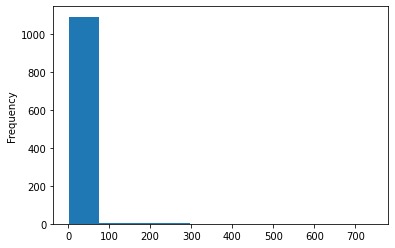

In [195]:
lower_speaker_title.value_counts().plot.hist()

In [196]:
lower_speaker_title.dropna(inplace=True)

In [197]:
lower_speaker_title

0                                 state representative
1                                       state delegate
2                                            president
5                           wisconsin assembly speaker
7                                            president
                             ...                      
10255                                  president elect
10257                                          senator
10258                      state senator, 8th district
10259                      senior editor, the atlantic
10266    chairman of the republican national committee
Name: speaker_title, Length: 7366, dtype: object

In [198]:
import editdistance

In [199]:
unique_speaker_title = lower_speaker_title.unique()

In [200]:
for i in range(0, len(unique_speaker_title)):
    for j in range(i, len(unique_speaker_title)):
        if i!=j and editdistance.eval(unique_speaker_title[i].strip(), unique_speaker_title[j].strip()) <= 2:
            print(i, j, unique_speaker_title[i], ", ",  unique_speaker_title[j])

7 1005 u.s. house member    4th district ,  u.s. house member    7th district
7 1006 u.s. house member    4th district ,  u.s. house member    6th district
7 1027 u.s. house member    4th district ,  u.s. house member    8th district
12 65 house minority leader ,  house majority leader
16 478 state senator ,  state senators
17 19 u.s. house of representative ,  u.s. house of representatives
19 782 u.s. house of representatives ,  n.c. house of representatives
31 1035 talk show host ,  talks show host
39 310 u.s. congressman ,  u. s. congressman
44 938 senate minority leader ,  senate majority leader
46 104 congressman ,  congresswoman
49 362 u.s. representative ,  u.s. representativej
50 468 state assembly member, 78th district ,  state assembly member, 95th district
52 1043 constable, travis county, precinct 5 ,  constable, travis county, precinct 2
55 177 politican action committee ,  political action committee
77 588 n.c. secretary of commerce ,  u.s. secretary of commerce
92 636 as

In [201]:
unique_speaker_title[0]

'state representative'

In [202]:
unique_speaker_title[834]

'senior vice president, hdr engineering'

In [203]:
train_df[train_df.speaker_title.str.contains("senator")]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [ ]:
train_df[train_df.speaker_title.str.lower().str.contains("senators").fillna(False)]

In [ ]:
train_df.speaker_title.str.contains("senator").fillna(False)

In [ ]:
train_df.iloc[478]

In [ ]:
train_df.speaker

In [ ]:
train_df.speaker.value_counts()[:35]

In [ ]:
train_df.party_affiliation.unique()

In [ ]:
train_df[train_df.party_affiliation=="0"]

In [ ]:
train_df.info()

In [ ]:
train_df.pants_fire_count.unique()

In [204]:
train_df.barely_true_count

0         0.0
1         0.0
2        70.0
3         7.0
4        15.0
         ... 
10262     0.0
10263     0.0
10264     4.0
10265     3.0
10266     0.0
Name: barely_true_count, Length: 10266, dtype: float64

In [205]:
train_df.barely_true_count.describe()


count    10266.000000
mean        11.557276
std         19.001815
min          0.000000
25%          0.000000
50%          2.000000
75%         12.000000
max         70.000000
Name: barely_true_count, dtype: float64

In [231]:
np.histogram_bin_edges(train_df.barely_true_count,bins="doane")

array([ 0.        ,  3.33333333,  6.66666667, 10.        , 13.33333333,
       16.66666667, 20.        , 23.33333333, 26.66666667, 30.        ,
       33.33333333, 36.66666667, 40.        , 43.33333333, 46.66666667,
       50.        , 53.33333333, 56.66666667, 60.        , 63.33333333,
       66.66666667, 70.        ])

In [219]:
np.histogram_bin_edges(train_df.false_count,bins="doane")

array([  0.        ,   5.18181818,  10.36363636,  15.54545455,
        20.72727273,  25.90909091,  31.09090909,  36.27272727,
        41.45454545,  46.63636364,  51.81818182,  57.        ,
        62.18181818,  67.36363636,  72.54545455,  77.72727273,
        82.90909091,  88.09090909,  93.27272727,  98.45454545,
       103.63636364, 108.81818182, 114.        ])

In [218]:
np.histogram_bin_edges(train_df.half_true_count,bins="doane")

array([  0.        ,   7.27272727,  14.54545455,  21.81818182,
        29.09090909,  36.36363636,  43.63636364,  50.90909091,
        58.18181818,  65.45454545,  72.72727273,  80.        ,
        87.27272727,  94.54545455, 101.81818182, 109.09090909,
       116.36363636, 123.63636364, 130.90909091, 138.18181818,
       145.45454545, 152.72727273, 160.        ])

In [215]:
np.histogram_bin_edges(train_df.mostly_true_count,bins="doane")

array([  0.        ,   7.40909091,  14.81818182,  22.22727273,
        29.63636364,  37.04545455,  44.45454545,  51.86363636,
        59.27272727,  66.68181818,  74.09090909,  81.5       ,
        88.90909091,  96.31818182, 103.72727273, 111.13636364,
       118.54545455, 125.95454545, 133.36363636, 140.77272727,
       148.18181818, 155.59090909, 163.        ])

In [217]:
np.histogram_bin_edges(train_df.pants_fire_count,bins="doane")

array([  0.        ,   4.77272727,   9.54545455,  14.31818182,
        19.09090909,  23.86363636,  28.63636364,  33.40909091,
        38.18181818,  42.95454545,  47.72727273,  52.5       ,
        57.27272727,  62.04545455,  66.81818182,  71.59090909,
        76.36363636,  81.13636364,  85.90909091,  90.68181818,
        95.45454545, 100.22727273, 105.        ])

In [212]:
train_df.pants_fire_count.describe()

count    10266.000000
mean         6.198617
std         16.110747
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max        105.000000
Name: pants_fire_count, dtype: float64

In [221]:
def compute_bin_idx(val: float, bins: List[float]) -> int:
    for idx, bin_val in enumerate(bins):
        if val <= bin_val:
            return idx

In [226]:
compute_bin_idx(4, [0, 3, 4, 5])

2

In [227]:
np.histogram_bin_edges(train_df.pants_fire_count,bins=10)

array([  0. ,  10.5,  21. ,  31.5,  42. ,  52.5,  63. ,  73.5,  84. ,
        94.5, 105. ])

In [229]:
train_df.pants_fire_count.describe()

count    10266.000000
mean         6.198617
std         16.110747
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max        105.000000
Name: pants_fire_count, dtype: float64

In [230]:
list(np.histogram_bin_edges(train_df.pants_fire_count,bins=10))

[0.0, 10.5, 21.0, 31.5, 42.0, 52.5, 63.0, 73.5, 84.0, 94.5, 105.0]

In [232]:
json_df = pd.read_json("/Users/mihaileric/Documents/Projects/fake-news/data/processed/cleaned_train_data.json")

In [233]:
len(json_df)

51335

In [234]:
len(train_df)

10266

51330